In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
# Configuration for plotting aesthetics
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

###Calculating Hessian Scores For each layer##

/tmp/ipykernel_247483/1246650714.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path)
/tmp/ipykernel_247483/1246650714.py:10: FutureWarning

Hessian scores for resnet18: [1.0017032623291016, 0.18025363981723785, 0.20660719275474548, 0.14873908460140228, 0.03709803894162178, 0.06941515952348709, 0.05078806355595589, 0.18911710381507874, 0.030530350282788277, 0.013526097871363163, 0.053409330546855927, 0.05847615376114845, 0.04696335643529892, 0.06016463041305542, 0.025153230875730515, 0.017811065539717674, 0.010238608345389366, 0.005445459391921759, 0.006352472119033337, 0.0001936535263666883, 0.02373744174838066]


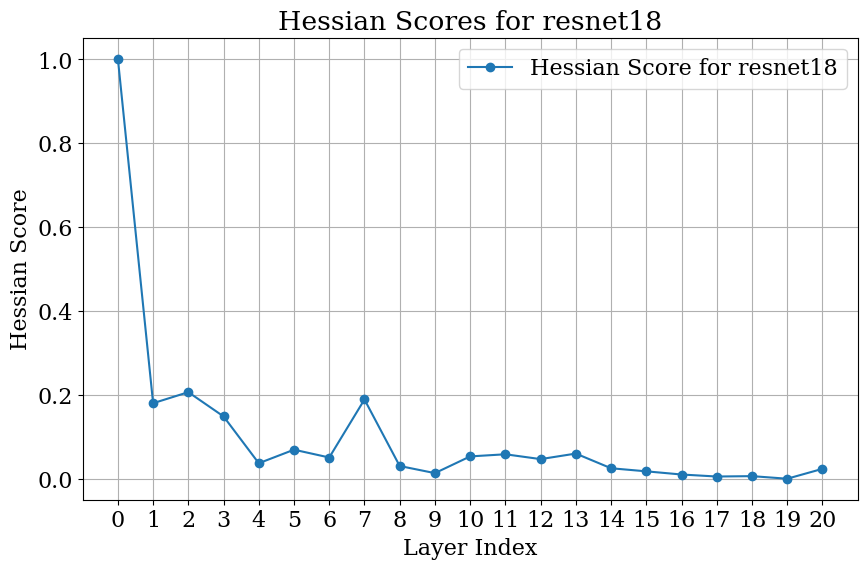

Hessian scores for densenet40: [4.578423500061035, 0.5213940143585205, 0.26985791325569153, 0.4354666769504547, 0.268091082572937, 0.39317482709884644, 0.27460452914237976, 0.48714786767959595, 0.24677017331123352, 0.5308612585067749, 0.1788853108882904, 0.6474390029907227, 0.16008234024047852, 0.6850417256355286, 0.2626596987247467, 0.19033493101596832, 0.24450427293777466, 0.22074846923351288, 0.34267544746398926, 0.19503846764564514, 0.2599107325077057, 0.17985600233078003, 0.21506494283676147, 0.1638813465833664, 0.2536592483520508, 0.15104825794696808, 0.43142464756965637, 0.18385855853557587, 0.25418365001678467, 0.11592844873666763, 0.23827746510505676, 0.11030003428459167, 0.3418194353580475, 0.1253465712070465, 0.25728657841682434, 0.09266608953475952, 0.42055201530456543, 0.1093844547867775, 0.4065791666507721, 0.18909919261932373, 0.15924984216690063, 0.23208533227443695, 0.1550799012184143, 0.2749561071395874, 0.15484951436519623, 0.2581173777580261, 0.16409657895565033, 0.

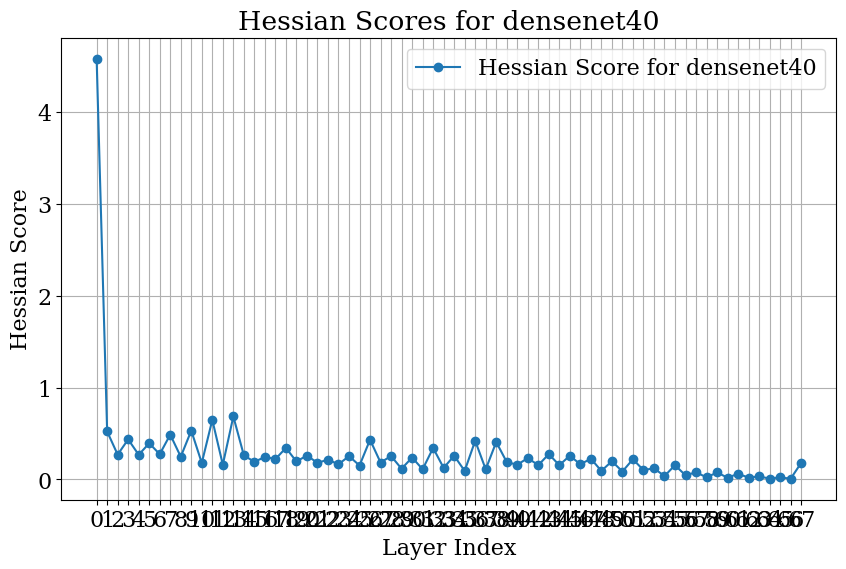

Hessian scores for vgg8: [2.685436248779297, 0.7272565960884094, 0.585945188999176, 0.40399476885795593, 0.2780877947807312, 0.02826455980539322, 0.016626577824354172, 0.1839577704668045]


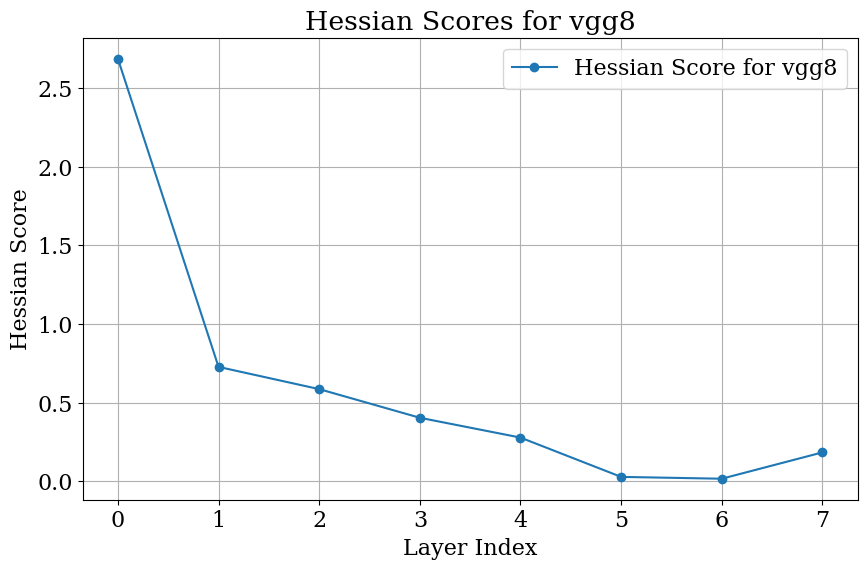

In [2]:
model_names = ['resnet18', 'densenet40', 'vgg8']
hessian_scores = {model: [] for model in model_names}

# Calculating Hessian scores for each model
for model_name in model_names:
    weights_path = f'./trace_data/weights_{model_name}_cifar10.pt'
    hessian_path = f'./hessian_pt/hessian_layer_{model_name}.pt'

    weights = torch.load(weights_path)
    hessian = torch.load(hessian_path)
    x_ticks = np.arange(len(weights))
    for i in range(len(weights)):
        squared_weights = weights[i]**2
        tensor_squared_weights =  torch.from_numpy(squared_weights).view(-1)
        hessian_layer = hessian[i].view(-1).cpu()
        hessian_scores[model_name].append(torch.dot(tensor_squared_weights, hessian_layer).item())

    print(f'Hessian scores for {model_name}:', hessian_scores[model_name])
    # Plotting the Hessian scores for this specific model
    plt.figure(figsize=(10, 6))
    plt.plot(hessian_scores[model_name], marker='o', linestyle='-', label=f'Hessian Score for {model_name}')
    plt.title(f'Hessian Scores for {model_name}')
    plt.xlabel('Layer Index')
    plt.ylabel('Hessian Score')
    plt.legend()
    plt.grid(True)
    plt.xticks(x_ticks)
    plt.show()

# # Plotting the Hessian scores for each model
# plt.figure(figsize=(10, 6))
# for model_name in model_names:
#     plt.plot(hessian_scores[model_name], label=model_name)

# plt.title('Hessian Scores by Model')
# plt.xlabel('Layer Index')
# plt.ylabel('Hessian Score')
# plt.legend()
# plt.grid(True)
# plt.show()

##Helper Functions to find the top-k critical element##

In [3]:
import torch

def top_10_percent_boolean(tensor, num_elements):
    """
    Create a boolean tensor where the top 10% of values (by magnitude) are True, and the rest are False.
    
    :param tensor: Input tensor
    :return: Boolean tensor with True for top 10% magnitude values
    """
    # Flatten the tensor to simplify processing
    flat_tensor = tensor.flatten()
    
    # Compute the threshold value for the top 10% by magnitude
    k = int(0.1 * num_elements)  # Number of top elements
    if k == 0:
        raise ValueError("Tensor size is too small to compute top 10%.")
    
    # Find the top-k values by magnitude
    threshold = torch.topk(flat_tensor, k).values.min()
    
    # Create a boolean tensor
    boolean_tensor = (tensor >= threshold)
    
    return boolean_tensor

# Example Usage
# tensor = torch.randint(1,10,(8,8)) # Example 4x4 tensor
# print("Input Tensor:\n", tensor)

# boolean_tensor = top_10_percent_boolean(tensor)
# print("Boolean Tensor (Top 10% by Magnitude):\n", boolean_tensor)
import torch

import torch

def replicate_last_dimension(tensor, num_times):
    """
    Replicate the last dimension of a tensor `num_times` times.
    
    :param tensor: Input tensor of shape (..., d)
    :param num_times: Number of times to replicate the last dimension
    :return: Tensor with the last dimension replicated, shape (..., num_times * d)
    """
    if num_times <= 0:
        raise ValueError("The number of times to replicate must be positive.")

    # Get the original shape of the tensor
    *leading_dims, last_dim = tensor.shape

    # Reshape the tensor to prepare for replication
    tensor = tensor.unsqueeze(-1)  # Add a new dimension after the last dimension

    # Repeat the tensor along the new dimension
    replicated_tensor = tensor.repeat_interleave(num_times, dim=-1)

    # Reshape the tensor to merge the replicated dimension with the original last dimension
    replicated_tensor = replicated_tensor.view(*leading_dims, num_times * last_dim)

    return replicated_tensor

# Example Usage
tensor = torch.tensor([
    [[1, 2], [3, 4]],
    [[5, 6], [7, 8]]
])  # Shape: (2, 2, 2)

# num_times = 3
# replicated_tensor = replicate_last_dimension(boolean_tensor, num_times)

# print("Original Tensor Shape:", boolean_tensor.shape)
# print("Original Tensor:\n", boolean_tensor)
# print("Replicated Tensor Shape:", replicated_tensor.shape)
# print("Replicated Tensor:\n", replicated_tensor)


In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from math import ceil

quantization_res=8

def quantize_dac(input, scale_max):
    min_val = input.min()
    max_val = input.max()
    
    # Normalize the input to 0-1 range and scale it to 0-scale_max
    output = (input - min_val) / (max_val - min_val) * scale_max
    output = torch.clamp(output, 0, scale_max)  # Ensuring the range is within 0-scale_max
    output = torch.round(output)  # Quantizing to nearest integer

    return output


# quantization function of DAC module

# quantize_weight = quantize_dac
# quantize_input = quantize_dac
def weight_sum_along_rows(tensor, K):
    # Step 1: Count occurrences of 0, 1, 2, 3 along dimension d
    values_to_count = [0, 1, 2, 3]
    counts = torch.stack([torch.sum(tensor == value, dim=-1, keepdim=True) for value in values_to_count], dim=-1)

    # Step 2: Perform the required calculations and sum them
    # Assuming K is a tensor of shape (4,) containing K_00, K_01, K_02, K_03
    # print(counts)
    results = counts * K * 3  # This will broadcast K along the other dimensions
    
    final_result = torch.sum(results, dim=-1)  # Sum across the last dimension

    return final_result
def count_bits(tensor):
    # Initialize a tensor of the same shape to store the counts of ones
    counts = torch.zeros_like(tensor, dtype=torch.int)
    # Loop through each bit position (0 to 7 for 8-bit integers)
    for shift in range(8):
        counts += (tensor >> shift) & 1
    return counts

def num_pad(source, target):
    crxb_index = ceil(source / target)
    num_padding = crxb_index * target - source
    return crxb_index, num_padding
def num_pad_col( source, target):
    crxb_col_fit = target/(quantization_res/2)
    crxb_index = ceil((source * (quantization_res/2)) / target)
    num_padding =int( crxb_index * target / (quantization_res/2) - source)
    return crxb_index, num_padding
def bit_slice_tensor(tensor, wp, cp):
    # Calculate the number of slices needed
    num_slices = wp // cp
    cellRange = 2 ** cp  # The maximum value each slice can have plus one (since we are slicing 2^cp bits each time)

    # Convert tensor to integers if not already
    tensor = tensor.to(torch.int32)
    
    # Prepare the output tensor shape
    output_shape = (*tensor.shape[:-1], tensor.shape[-1] * num_slices)
    output = torch.zeros(output_shape, dtype=torch.int8, device=tensor.device)
    
    # Calculate initial division factor to get the MSB first
    initial_divisor = 2 ** (wp - cp)
    
    # Perform bit slicing
    for i in range(num_slices):
        # Shift the tensor values right by the current bit offset
        shifted_tensor = tensor // initial_divisor
        # Extract the lowest cp bits using fmod from the shifted tensor
        extracted_bits = torch.fmod(shifted_tensor, cellRange)
        # Place extracted bits in the corresponding new dimension in the output tensor
        output[..., i::num_slices] = extracted_bits.to(torch.int8)
        # Reduce the division factor for the next more significant bits
        initial_divisor //= cellRange

    return output.float()

Get hessian scores for each tile/crossbars. 
1. Map the weights to crossbar. (Mapping adopted from PytorX-->Refer to tile in topk_inference)
2. Find hessian scores with respect to the tiles. 
3. Identify the protected cells to safgauard the topk critical weights. here k is 10\% 

In [5]:
##Tile Wise Hessian Score
import itertools

def create_heatmap_from_boolean_tensor(bool_tensor):
    """
    Create a heatmap structure from a 4D boolean tensor.

    :param bool_tensor: 4D boolean tensor of shape (a, b, c, d)
    :return: 2D heatmap representing counts of True values in the reduced dimensions
    """
    if bool_tensor.ndimension() != 4:
        raise ValueError("Input tensor must be 4-dimensional.")
    
    # Combine dimensions (a, c) and (b, d) to create a 2D structure
    a, b, c, d = bool_tensor.shape
    reshaped_tensor = bool_tensor.view(a * c, b * d)
    
    # Convert boolean values to integers and sum

    heatmap = reshaped_tensor.int()  # Convert to integers for summation
    #find the number of ones in the tensor
    total_ones = heatmap.flatten().sum()
    percentage_of_ones = total_ones/heatmap.numel()*100
    return heatmap, percentage_of_ones
def contains_negative(numbers):
    # Flatten the list of lists and check for any negative numbers
    return any(num < 0 for num in numbers)
def tile_info_and_weighted_sum_gen(model_name, dataset_name,weights, hessian):
    crxb_size = 128
    tile_size = 96 ## ISSAC config has 96 arrays in one tile
    max_weighted_sum_const = crxb_size*8*3*crxb_size
    
    col_size = int(crxb_size/(quantization_res/2))
    ##for conv and linear layers only
    hessian_tile_wise = []
    faults_tile_wise = []
    idx=0
    hessian_bool = []
    hessian_score_crxb = []
    for layerid in range(len(weights)):
        hessian_tile_wise.append([])
        if len(weights[layerid].shape) > 2: ## Conv layer. ##Hesians have same shape as weight. 
            num_elements = weights[layerid].numel()
            weight_flatten = weights[layerid].view(weights[layerid].shape[0], -1)
            hessian_flatten = hessian[layerid].view(hessian[layerid].shape[0], -1)
            crxb_row, crxb_row_pads = num_pad(weight_flatten.shape[1], crxb_size)
            crxb_col, crxb_col_pads = num_pad_col(weight_flatten.shape[0], crxb_size)
            w_pad = (0,  crxb_col_pads, 0,crxb_row_pads)
            weight_flatten = weight_flatten.transpose(0, 1)
            hessian_flatten = hessian_flatten.transpose(0, 1)

            # 2.2. add paddings
            weight_padded = F.pad(weight_flatten, w_pad,  mode='constant', value=0)
            weight_crxb = weight_padded.reshape(crxb_row,  crxb_col, crxb_size, col_size)
            hessian_padded = F.pad(hessian_flatten, w_pad,  mode='constant', value=0)
            hessian_crxb = hessian_padded.reshape(crxb_row,  crxb_col, crxb_size, col_size)
            hessian_score_shape = (hessian_crxb.shape[0], hessian_crxb.shape[1])
            hessian_Score = torch.zeros(hessian_score_shape)
            for row_crxb in range(hessian_crxb.shape[0]):
                for col_crxb in range(hessian_crxb.shape[1]):
                    hessian_Score[row_crxb][col_crxb] = torch.dot(hessian_crxb[row_crxb][col_crxb].flatten(), weight_crxb[row_crxb][col_crxb].flatten()**2)
            
            ## Foeach tile size sum the hessian score
            hessian_score_flatten = hessian_Score.view(-1)
            for i in range(0, hessian_score_flatten.size(0), tile_size):
                hessian_tile_wise[layerid].append(torch.sum(hessian_score_flatten[i:i+tile_size]).item())
            
            hessian_score_weight = hessian_crxb* weight_crxb**2
            hessian_score_crxb.append(hessian_score_weight)

            ##remove the paddings from the boolean tensor
            # hessian_score_un
            bool_tensor = top_10_percent_boolean(hessian_score_weight,num_elements)
            hessian_bool.append(replicate_last_dimension(bool_tensor, 4))
            # print(bool_tensor.shape)
            heatmap, percentage_of_ones = create_heatmap_from_boolean_tensor(bool_tensor)
            total_ones_in_crxb = []
            for a in range(bool_tensor.shape[0]):
                for c in range(bool_tensor.shape[1]):
                    total_ones_in_crxb.append(bool_tensor[a][c].sum().item())
            print("total ones of crxb in layer", layerid, total_ones_in_crxb)
            ##get total ones in tiles
            total_ones_in_tiles = []
            num_elements_in_tiles = tile_size*crxb_size*col_size
            for i in range(0, len(total_ones_in_crxb), tile_size):
                total_ones_in_tiles.append(sum(total_ones_in_crxb[i:i+tile_size])/num_elements_in_tiles*100)
            # print(total_ones_in_tiles)
            print("total ones of tiles in layer", layerid, total_ones_in_tiles)
            faults_tile_wise.append(total_ones_in_tiles)
            # Plot the heatmap
            # plt.figure(figsize=(8, 6))
            # plt.imshow(heatmap, cmap='Greys', interpolation='nearest')
            # plt.colorbar(label='True Count')
            # plt.title('Heatmap of Boolean Tensor for layer {},\n total percentage{}'.format(layerid,percentage_of_ones))
            # plt.xlabel('b * d')
            # plt.ylabel('a * c')
            # plt.show()

        else: ##Linear layer. 
            num_elements = weights[layerid].numel()
            crxb_row, crxb_row_pads = num_pad(weights[layerid].shape[1], crxb_size)
            crxb_col, crxb_col_pads = num_pad_col(weights[layerid].shape[0], crxb_size)
            w_pad = (0,  crxb_col_pads, 0,crxb_row_pads)
            weight_flatten = weights[layerid].transpose(0, 1)
            hessian_flatten = hessian[layerid].transpose(0, 1)
            # 2.2. add paddings
            weight_padded = F.pad(weight_flatten, w_pad,  mode='constant', value=0)
            weight_crxb = weight_padded.reshape(crxb_row,  crxb_col, crxb_size, col_size)
            hessian_padded = F.pad(hessian_flatten, w_pad,  mode='constant', value=0)
            hessian_crxb = hessian_padded.reshape(crxb_row,  crxb_col, crxb_size, col_size)
            hessian_score_shape = (hessian_crxb.shape[0], hessian_crxb.shape[1])
            hessian_Score = torch.zeros(hessian_score_shape)
            for row_crxb in range(hessian_crxb.shape[0]):
                for col_crxb in range(hessian_crxb.shape[1]):
                    hessian_Score[row_crxb][col_crxb] = torch.dot(hessian_crxb[row_crxb][col_crxb].flatten(), weight_crxb[row_crxb][col_crxb].flatten()**2)
            hessiam_score_flatten = hessian_Score.view(-1)
            for i in range(0, hessiam_score_flatten.size(0), tile_size):
                hessian_tile_wise[layerid].append(torch.sum(hessiam_score_flatten[i:i+tile_size]).item())
            hessian_score_weight = hessian_crxb* weight_crxb**2
            hessian_score_crxb.append(hessian_score_weight)
            bool_tensor = top_10_percent_boolean(hessian_score_weight,num_elements)
            hessian_bool.append(replicate_last_dimension(bool_tensor, 4))
            # print(bool_tensor.shape)
            heatmap, percentage_of_ones = create_heatmap_from_boolean_tensor(bool_tensor)

            total_ones_in_crxb = []
            for a in range(bool_tensor.shape[0]):
                for c in range(bool_tensor.shape[1]):
                    total_ones_in_crxb.append(bool_tensor[a][c].sum().item())
            print("total ones of crxb in layer", layerid, total_ones_in_crxb)
            ##get total ones in tiles
            total_ones_in_tiles = []
            num_elements_in_tiles = tile_size*crxb_size*col_size
            for i in range(0, len(total_ones_in_crxb), tile_size):
                total_ones_in_tiles.append(sum(total_ones_in_crxb[i:i+tile_size])/num_elements_in_tiles*100)
            # print(total_ones_in_tiles)
            print("total ones of tiles in layer", layerid, total_ones_in_tiles)
            faults_tile_wise.append(total_ones_in_tiles)
            # Plot the heatmap
            # plt.figure(figsize=(8, 6))
            # plt.imshow(heatmap, cmap='Greys', interpolation='nearest')
            # plt.colorbar(label='True Count')
            # plt.title('Heatmap of Boolean Tensor for layer {} \ntotal percentage{}'.format(layerid,percentage_of_ones))
            # plt.xlabel('b * d')
            # plt.ylabel('a * c')
            # plt.show()
    
    ##save the tile info and power trace
    # print(hessian_tile_wise)
    # print(len(hessian_tile_wise))
    
    ## Merge all sublists into one list
    # merged_list = list(itertools.chain.from_iterable(hessian_tile_wise))
    # print(merged_list)
    # print(f'Total Tiles: {len(merged_list)}')
    # result = contains_negative(merged_list)
    # print("Contains negative:", result)
    # torch.save(merged_list, f'./hessian_tile_wise/hessian_tile_wise_{model_name}.pt')
    # torch.save(hessian_bool, f'./hessian_bool/hessian_bool_{model_name}.pt')
    merged_list = list(itertools.chain.from_iterable(faults_tile_wise))
    print(merged_list)
    print(f'Total Tiles: {len(merged_list)}')
    torch.save(merged_list, f'./faults_tile_wise/faults_tile_wise_{model_name}.pt')
    torch.save(hessian_score_crxb, f'./hessian_score_crxb/hessian_score_crxb_{model_name}.pt')

# Plot percentgae of cells to protect per tile


In [6]:
import numpy as np
def find_tensors_with_negatives(tensor_list):
    # List to store indices of tensors that contain negative values
    negative_tensor_indices = []
    
    for index, tensor in enumerate(tensor_list):
        # Check if there is any negative value in the tensor
        if torch.any(tensor < 0):
            negative_tensor_indices.append(index)
    
    return negative_tensor_indices
# model_names = ['resnet18']
model_names = ['resnet18', 'densenet121', 'densenet40', 'lenet', 'vgg8']
device = torch.device("cpu")
for model_name in model_names:
    weights_path = f'./trace_data/weights_{model_name}_cifar10.pt'
    hessian_path = f'./hessian_pt/hessian_layer_{model_name}.pt'

    weights = torch.load(weights_path, map_location=device)
    hessian = torch.load(hessian_path, map_location=device)
    negative_indices = find_tensors_with_negatives(hessian)
    print("Indices of tensors with negative values:", negative_indices)
    ## converts to tensor from numpy
    weights = [torch.from_numpy(w) for w in weights]
    tile_info_and_weighted_sum_gen(model_name, 'cifar10',weights, hessian)
    print(f'{model_name} done')

/tmp/ipykernel_7626/3822617235.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location=device)
/tmp/ipykernel_7626/3822617235.py

Indices of tensors with negative values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
total ones of crxb in layer 0 [172, 0]
total ones of tiles in layer 0 [0.04374186197916667]
total ones of crxb in layer 1 [232, 468, 333, 603, 534, 439, 534, 535, 8, 0]
total ones of tiles in layer 1 [0.9373982747395834]
total ones of crxb in layer 2 [303, 519, 677, 111, 180, 576, 285, 510, 525, 0]
total ones of tiles in layer 2 [0.9373982747395834]
total ones of crxb in layer 3 [290, 438, 467, 401, 524, 427, 299, 413, 427, 0]
total ones of tiles in layer 3 [0.9373982747395834]
total ones of crxb in layer 4 [228, 422, 546, 244, 567, 623, 420, 453, 183, 0]
total ones of tiles in layer 4 [0.9373982747395834]
total ones of crxb in layer 5 [323, 171, 441, 520, 467, 512, 415, 340, 769, 253, 617, 359, 73, 348, 463, 402, 428, 471, 0, 0]
total ones of tiles in layer 5 [1.8747965494791667]
total ones of crxb in layer 6 [645, 657, 162, 278, 583, 374, 269, 276, 502, 425, 455, 541, 5

Plot percentage of protected cells per tile

/tmp/ipykernel_402788/3366732481.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  faults_tile_wise = torch.load(f'./faults_tile_wise/faults_tile_wise_{model_name}.pt')


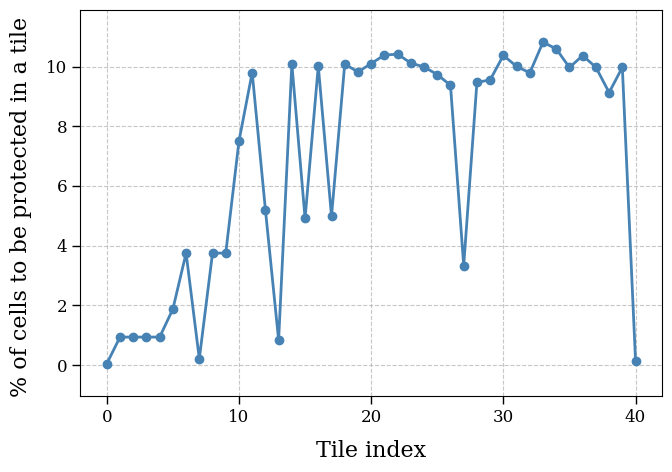

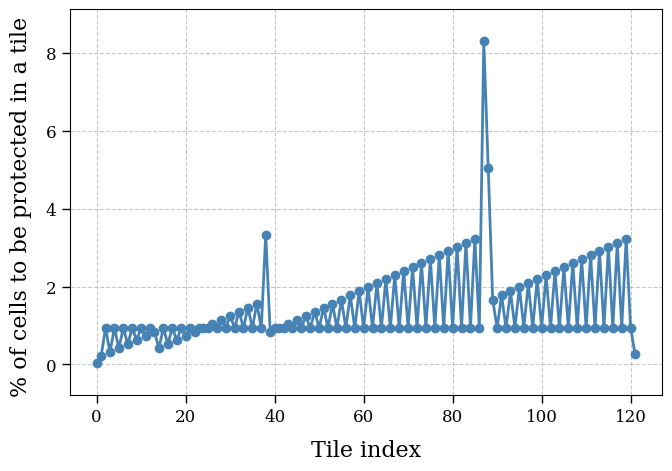

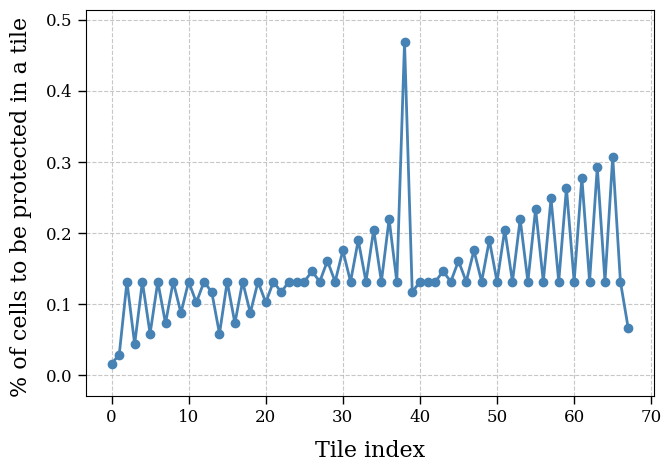

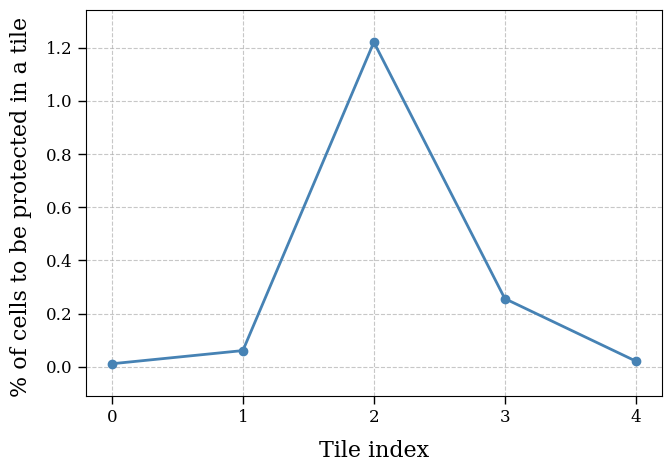

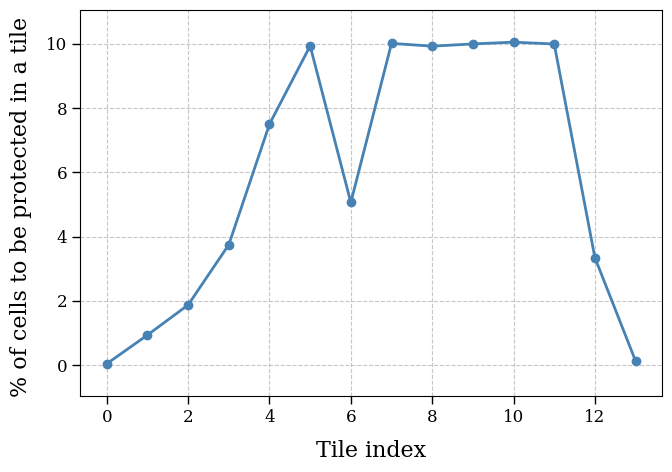

In [ ]:
import torch
import matplotlib.pyplot as plt
model_names = ['resnet18', 'densenet40', 'vgg8']
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16
for model_name in model_names:
    ##load fault list and plot 
    faults_tile_wise = torch.load(f'./faults_tile_wise/faults_tile_wise_{model_name}.pt')
    # Create the plot
    plt.figure(figsize=(7, 5))  # Set figure size
    plt.plot(faults_tile_wise, color='steelblue', linewidth=2, marker = 'o')  # Adjust line color and width
    
    # Add labels and title
    plt.xlabel('Tile index', fontsize=16, labelpad=10)
    plt.ylabel('% of cells to be protected in a tile ', fontsize=16, labelpad=10)
    # plt.title(f'Faults in Tiles for {model_name}', fontsize=18, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    
    # Adjust tick parameters
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tick_params(axis='both', which='major', length=6, width=1)
    
    # Improve spacing
    plt.margins(x=0.05, y=0.1)
    plt.tight_layout()
    
    # Display the plot
    plt.savefig(f'./faults_tile_wise_{model_name}.png', dpi = 300)
    plt.show()


